In [1]:
import os;
import sys;
import random;
import math
import json
import imutils;

import numpy as np;
import cv2;
import matplotlib.pyplot as plt;

from skimage.feature import greycomatrix, greycoprops,local_binary_pattern


import tensorflow as tf
from tensorflow import keras;

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc

from keras import backend as K


import mahotas as mt
import sklearn

from skimage.filters import gabor



from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D 


import umap
import phate

from pywt import dwt2


/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/dlenv3/lib/python3.6/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
with open("result/forautoencoder.json") as f:
    data = json.load(f)

In [3]:
ids=[];
label =[];
colors =[];


for i in data:
    ids.append(i)
    label.append(data[i]["label"])
    
    
    if data[i]["label"] == "normal":
        colors.append("green");
        
    elif data[i]["label"] == "dss":
        colors.append("red");
        
    elif data[i]["label"] == "treatment":
        colors.append("blue");
    else:
        print(data[i]["label"])

In [4]:
borders =[];
centers=[];
for i in data:
    ct = np.asarray(data[i]["center"])
    bd = np.asarray(data[i]["border"])
    
    borders.append(bd)
    centers.append(ct)
    
data=None;

In [5]:
borders=np.asarray(borders)/255.0
centers=np.asarray(centers)/255.0 

In [6]:
borders_ds32=[];
centers_ds32=[];
id_ds32=[];
label_ds32=[];
color_ds32=[];

for i in range(len(ids)):
    if ids[i].startswith("DSS-2018-32"):
        borders_ds32.append(borders[i]);
        centers_ds32.append(centers[i]);
        id_ds32.append(ids[i]);
        label_ds32.append(label[i]);
        color_ds32.append(colors[i])
        
        
borders_ds32=np.asarray(borders_ds32)
centers_ds32=np.asarray(centers_ds32)



In [7]:
combines_dss32=[];
for i in range(len(centers_ds32)):
    temp =np.zeros((24,24,72))
    temp[:,:,:36] = borders_ds32[i][:,:,:36]
    temp[:,:,36:] = centers_ds32[i][:,:,:36]
    combines_dss32.append(temp)
    
    
combines_dss32=np.asarray(combines_dss32)

In [8]:
ids=[];
label =[];
colors =[];
borders =[];
centers=[];
data=None;

borders_ds32=None;
centers_ds32=None;

In [10]:
def autoencoder():
    inputs = keras.layers.Input((24, 24, 72))
    d1 = keras.layers.Conv2D(96,(1,1),padding="same",activation="relu")(inputs);
    d1 = keras.layers.Conv2D(96,(3,3),padding="same",activation="relu")(d1);
    d1 = keras.layers.MaxPool2D((2,2),(2,2))(d1);


    d2 = keras.layers.Conv2D(64,(1,1),padding="same",activation="relu")(d1);
    d2 = keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(d2);
    d2 = keras.layers.MaxPool2D((2,2),(2,2))(d2);


    d1 = keras.layers.Conv2D(32,(1,1),padding="same",activation="relu")(d2);
    d1 = keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(d1);

    d1 = keras.layers.MaxPool2D((2,2),(2,2))(d1);


    d = keras.layers.Conv2D(24,(3,3),padding="same",activation="relu")(d1);
    d = keras.layers.Conv2D(24,(3,3),padding="same",activation="relu")(d);
    bn = keras.layers.MaxPool2D((2,2),(2,2))(d);

    flatten = keras.layers.Flatten()(bn)

    u = keras.layers.UpSampling2D((2,2))(d);
    u= keras.layers.Conv2D(32,(1,1),padding="same",activation="relu")(u);
    u= keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(u);

    u = keras.layers.UpSampling2D((2,2))(u);
    u= keras.layers.Conv2D(64,(1,1),padding="same",activation="relu")(u);
    u= keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(u);


    u = keras.layers.UpSampling2D((2,2))(u);
    u = keras.layers.Conv2D(96,(1,1),padding="same",activation="relu")(u);
    u = keras.layers.Conv2D(96,(3,3),padding="same",activation="relu")(u);


    outputs = keras.layers.Conv2D(72,(1,1),padding="same",activation='sigmoid')(u);
    
    autoencoder = keras.models.Model(inputs,outputs)

    encoder = keras.models.Model(inputs,flatten)
    
    autoencoder.compile(optimizer = "adam",loss="binary_crossentropy");
    
    
    return autoencoder , encoder


In [ ]:
autoencoder , encoder = autoencoder();

In [54]:
autoencoder.fit(combines_dss32,combines_dss32,epochs=2,batch_size=220,shuffle=True)

Train on 35269 samples
Epoch 1/2
35269/35269 [==============================] - 73s 2ms/sample - loss: 0.5970
Epoch 2/2
35269/35269 [==============================] - 74s 2ms/sample - loss: 0.5970


In [55]:
result = encoder.predict(combines_dss32)

In [92]:
#cluster

hc=sklearn.cluster.AgglomerativeClustering(n_clusters = 4,).fit_predict(result)

colordict=["blue","red","green","orange"]
colorlabels=[]
for i in hc:
    colorlabels.append(colordict[i])

In [ ]:
CB32_tsne = TSNE().fit_transform(result)

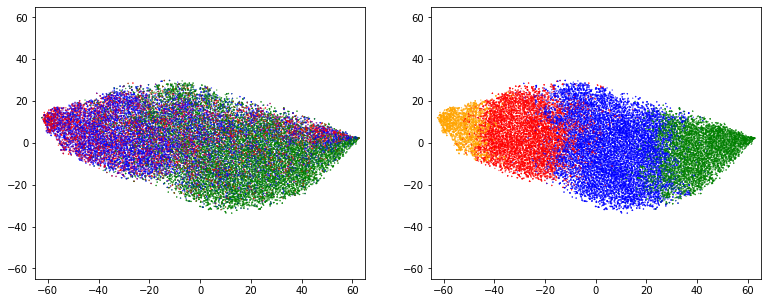

In [145]:
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(121)
ax.set_xlim(-65,65)
ax.set_ylim(-65, 65)
ax.scatter(CB32_tsne[:, 0], CB32_tsne[:, 1],c=color_ds32,s=0.1)
ax = fig.add_subplot(122)
ax.set_xlim(-65,65)
ax.set_ylim(-65, 65)
ax.scatter(CB32_tsne[:, 0], CB32_tsne[:, 1],c=colorlabels,s=0.1)

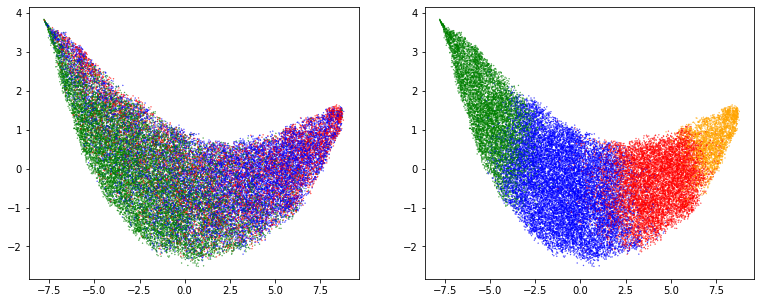

In [99]:

fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(121)
ax.scatter(CB32_umap[:, 0], CB32_umap[:, 1],c=color_ds32,s=0.1)
ax = fig.add_subplot(122)
ax.scatter(CB32_umap[:, 0], CB32_umap[:, 1],c=colorlabels,s=0.1)

In [163]:
slidedata=dict();

ids32 = id_ds32
for i in range(len(ids32)):
    name = ids32[i].split("___")[0];
    slidedata[name]={"color":color_ds32[i],"umap":[],"phate":[],"tsne":[]};
    
for i in range(len(ids32)):
    name = ids32[i].split("___")[0];
    coor = CB32_umap[i];
    slidedata[name]["umap"].append(coor);
    
    coor = CB32_tsne[i];
    slidedata[name]["tsne"].append(coor);
    
for i in slidedata:
    coors = slidedata[i]["umap"];
    xs=[];
    ys=[];
    for c in coors:
        xs.append(c[0])
        ys.append(c[1])
    
    
    mean = np.mean(xs);
    std = np.std(xs)
    xs = [x for x in xs if (x > mean - 2 * std)]
    xs = [x for x in xs if (x < mean + 2 * std)]
    
    mean = np.mean(ys);
    std = np.std(ys)
    ys = [x for x in ys if (x > mean - 2 * std)]
    ys = [x for x in ys if (x < mean + 2 * std)]
    
    xs = sum(xs)/len(xs)
    ys = sum(ys)/len(ys)
    
    slidedata[i]["umap"]=(xs,ys);
    
    
    coors = slidedata[i]["phate"];
    xs=[];
    ys=[];
    for c in coors:
        xs.append(c[0])
        ys.append(c[1])
        
        
    mean = np.mean(xs);
    std = np.std(xs)
    xs = [x for x in xs if (x > mean - 2 * std)]
    xs = [x for x in xs if (x < mean + 2 * std)]
    
    mean = np.mean(ys);
    std = np.std(ys)
    ys = [x for x in ys if (x > mean - 2 * std)]
    ys = [x for x in ys if (x < mean + 2 * std)]
        
    xs = sum(xs)/len(xs)
    ys = sum(ys)/len(ys)
    
    slidedata[i]["phate"]=(xs,ys);
    
    
    coors = slidedata[i]["tsne"];
    xs=[];
    ys=[];
    for c in coors:
        xs.append(c[0])
        ys.append(c[1])
        
        
        
    mean = np.mean(xs);
    std = np.std(xs)
    xs = [x for x in xs if (x > mean - 2 * std)]
    xs = [x for x in xs if (x < mean + 2 * std)]
    
    mean = np.mean(ys);
    std = np.std(ys)
    ys = [x for x in ys if (x > mean - 2 * std)]
    ys = [x for x in ys if (x < mean + 2 * std)]
        
    xs = sum(xs)/len(xs)
    ys = sum(ys)/len(ys)
    
    slidedata[i]["tsne"]=(xs,ys);

In [164]:
slidecolors=[];
slideumap=[];
slidephate=[];
slidetsne=[];
slideid=[]
for i in slidedata:
    slidecolors.append(slidedata[i]["color"]);
    slideumap.append(list(slidedata[i]["umap"]));
    slidephate.append(list(slidedata[i]["phate"]));
    slidetsne.append(list(slidedata[i]["tsne"]));
    slideid.append(i)
slideumap=np.asarray(slideumap)
slidephate=np.asarray(slidephate)
slidetsne=np.asarray(slidetsne)

In [151]:
mapdata=CB32_tsne;
ids = id_ds32;
labels = label_ds32;

data=[];
for i in range(len(ids)):
    
    data.append(ids[i]+","+labels[i]+","+str(mapdata[i][0]*1.8)+","+str(mapdata[i][1]*1.8))

data = "\n".join(data)

with open("/home/ubuntu/project/pythologyImageDL/scatterplot/data/new_gland_tsne32.csv" ,"w") as f:
    f.write(data)


In [121]:
mapdata=CB32_umap;
ids = id_ds32;
labels = label_ds32;

data=[];
for i in range(len(ids)):
    
    data.append(ids[i]+","+labels[i]+","+str(mapdata[i][0]*10)+","+str(mapdata[i][1]*20))

data = "\n".join(data)

with open("/home/ubuntu/project/pythologyImageDL/scatterplot/data/new_gland_umap32.csv" ,"w") as f:
    f.write(data)